In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import(
    accuracy_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
    f1_score, 
    precision_score, 
    recall_score, 
)
from typing import List

In [2]:
# Read in data
training_data = pd.read_csv("Data/train.csv")

In [3]:
# Split Passenger ID into Group number and position columns
training_data[["GroupNum", "GroupPosition"]] = (
    training_data
    .PassengerId
    .str
    .split("_", expand=True)
)

# Splitting Cabin into Deck, Room number, and side of ship 
training_data[["Deck", "RoomNum", "Side"]] = (
    training_data
    .Cabin
    .str
    .split("/", expand=True)
)

# Convert Data to proper types
training_data["GroupNum"] = training_data.GroupNum.astype('Int64')
training_data["GroupPosition"] = training_data.GroupPosition.astype('Int64')
training_data["RoomNum"] = training_data.RoomNum.astype('Int64')
training_data["CryoSleep"] = training_data.CryoSleep.astype(bool)
training_data["VIP"] = training_data.VIP.astype(bool)


# EDA

## Numerical Variables

In [4]:
#Seperating Data into numerical columns then created a for loop to display the distribution of each column
numerical_variables = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for col_name in numerical_variables:
    fig=px.histogram(
        training_data, 
        x=col_name, 
        title=f'Distribution of {col_name}'
    )
    fig.show()

## Categorical Variables

In [5]:
def categorical_variable_survival_ratio(data_frame: pd.DataFrame, column_name:str, base:float=0) -> pd.DataFrame:
    """Generate ratio of passengers transported vs not transported for every value in a categorical variable. 
       Can subtract proportions from a base value to display difference from base value

    Args:
        data_frame (pd.DataFrame): Data Frame containing passenger information
        column_name (str): Name of column containing categorical variable
        base (float, optional): Value to calculate difference from. Defaults to 0.

    Returns:
        pd.DataFrame: _description_
    """
    # Calculate total amount for each value in column
    total_values = (
        data_frame[column_name]
        .value_counts()
        .reset_index()
        .rename(columns={'count':"total"})
    )

    # Calculate amount of of survivors and no-survivors for each value in column
    transported_values = (
        data_frame
        .groupby([column_name, "Transported"])
        .count()["PassengerId"]
        .reset_index()
        .rename(columns={'PassengerId':"amount"})
    )

    # Calculate survival ratio
    survival_rates = total_values.merge(transported_values)
    survival_rates["SurvivalRatio"] = survival_rates.amount / survival_rates.total

    # Pivot Table
    survival_rates = survival_rates.pivot(
        columns="Transported",
        index=column_name,
        values="SurvivalRatio"
    )

    return survival_rates - base


def plot_categorical_values(dataframe:pd.DataFrame, column_name:str) -> None:
    counts_per_value = (
        dataframe[column_name]
        .value_counts()
        .reset_index()
    )

    fig = px.bar(
        counts_per_value, 
        x =column_name,
        y="count",
        width=900,
        height=600,
        color=column_name,
        text_auto=True
    )

    fig.update_layout(
        showlegend=False
    )

    fig.update_yaxes(title="Number of Passengers")

    fig.show()
    

To determine whether or not a categorical variable had an impact or not, we are comparing the proportion of each value of that categorical variable to the proportion of total passengers who were transported. For an example, since the total number of passengers who transported away is roughly 50%, if a variable did not have impact on survival, we expect the amount of passengers transported away for the value of that categorical variable to be arround 50% as well. To make comparison easier, the difference between the proportion of passengers who transported away per value in the categorical variable and the total number passengers who transported away was taken. 

In [6]:
# Calculate ratio of total transported passengers
total_transported_passengers = (
    training_data
    .query("Transported == True")
    .shape[0]
)

total_passengers = training_data.shape[0]

transported_proportion = total_transported_passengers / total_passengers

### Home Planet

In [7]:
plot_categorical_values(training_data, "HomePlanet")

In [8]:
categorical_variable_survival_ratio(training_data, "HomePlanet", transported_proportion)

Transported,False,True
HomePlanet,,
Earth,0.072430,-0.079677
Europa,-0.162469,0.155222
Mars,-0.026648,0.019401


### CryoSleep

In [9]:
plot_categorical_values(training_data, "CryoSleep")

In [10]:
categorical_variable_survival_ratio(training_data, "CryoSleep", transported_proportion)

Transported,False,True
CryoSleep,,
False,0.167456,-0.174703
True,-0.299260,0.292013


### Destination

In [11]:
plot_categorical_values(training_data, "Destination")

In [12]:
categorical_variable_survival_ratio(training_data, "Destination", transported_proportion)

Transported,False,True
Destination,,
55 Cancri e,-0.113624,0.106376
PSO J318.5-22,-0.007392,0.000145
TRAPPIST-1e,0.025201,-0.032449


### VIP

In [13]:
plot_categorical_values(training_data, "VIP")

In [14]:
categorical_variable_survival_ratio(training_data, "VIP", transported_proportion)

Transported,False,True
VIP,,
False,-0.009956,0.002709
True,0.048615,-0.055862


### GroupPosition

In [15]:
plot_categorical_values(training_data, "GroupPosition")

In [16]:
categorical_variable_survival_ratio(training_data, "GroupPosition", transported_proportion)

Transported,False,True
GroupPosition,,
1,0.020423,-0.027671
2,-0.062405,0.055158
3,-0.121837,0.11459
4,-0.096697,0.08945
5,-0.050499,0.043251
6,-0.05029,0.043043
7,-0.003624,-0.003624
8,0.034838,-0.042085


### Deck

In [17]:
plot_categorical_values(training_data, "Deck")

In [18]:
categorical_variable_survival_ratio(training_data, "Deck", transported_proportion)

Transported,False,True
Deck,,
A,0.000283,-0.007530
B,-0.237898,0.230651
C,-0.183677,0.176430
D,0.063322,-0.070569
E,0.139070,-0.146318
F,0.056505,-0.063752
G,-0.019841,0.012594
T,0.296376,-0.303624


### Side

In [19]:
plot_categorical_values(training_data, "Side")

In [20]:
categorical_variable_survival_ratio(training_data, "Side", transported_proportion)

Transported,False,True
Side,,
P,0.045116,-0.052364
S,-0.058661,0.051414


### Age

In [21]:
def group_ages(value: int) -> str:
    """Converts Age into a categorical variaable

    Args:
        value (int): Age as a number

    Returns:
        str: Age category
    """
    if value < 10:
        return "Toddler"
    elif value < 20:
        return "Teen"
    elif value < 30:
        return "Young Adult"
    elif value < 50:
        return "Adult"
    else:
        return "Senior"

In [22]:
training_data["Age"] = training_data.Age.apply(group_ages)

In [23]:
plot_categorical_values(training_data, "Age")

In [24]:
categorical_variable_survival_ratio(training_data, "Age", transported_proportion)

Transported,False,True
Age,,
Adult,0.019553,-0.026800
Senior,0.007488,-0.014735
Teen,-0.036416,0.029169
Toddler,-0.214964,0.207717
Young Adult,0.027151,-0.034398


# Cleaning Data

In [25]:
# Dropping Passenger ID, Cabin, and Name because they are unused
training_data = training_data.drop(columns=["PassengerId", "Cabin", "Name"])

In [26]:
# One hot enconding
training_data = pd.get_dummies(training_data)

In [27]:
# Fill in nans with median for numerical values
for col_name in numerical_variables:
    if col_name != "Age":
        column_median = training_data[col_name].median()
        training_data[col_name] = training_data[col_name].fillna(column_median)

# Assign nan for RumNumber -1, a dummay value representing room unknown
training_data["RoomNum"] = training_data["RoomNum"].fillna(-1)

In [28]:
training_data.corr()["Transported"]

CryoSleep                    0.451744
VIP                         -0.024602
RoomService                 -0.241124
FoodCourt                    0.045583
ShoppingMall                 0.009391
Spa                         -0.218545
VRDeck                      -0.204874
Transported                  1.000000
GroupNum                     0.021491
GroupPosition                0.066390
RoomNum                     -0.043830
HomePlanet_Earth            -0.169019
HomePlanet_Europa            0.176916
HomePlanet_Mars              0.019544
Destination_55 Cancri e      0.108722
Destination_PSO J318.5-22    0.000092
Destination_TRAPPIST-1e     -0.094700
Age_Adult                   -0.036782
Age_Senior                  -0.010565
Age_Teen                     0.026415
Age_Toddler                  0.120927
Age_Young Adult             -0.046949
Deck_A                      -0.002623
Deck_B                       0.144733
Deck_C                       0.108193
Deck_D                      -0.034046
Deck_E      

In [29]:
# Aggregating spending into a single variable
training_data["TotalSpent"] = training_data.RoomService + training_data.FoodCourt + training_data.ShoppingMall + training_data.Spa + training_data.VRDeck

# Dropping columns with low correlation to "Transported"
training_data = training_data.drop(columns=["Side_P", "GroupPosition", "GroupNum", "Destination_PSO J318.5-22", 'Destination_TRAPPIST-1e', "Age_Adult", "Age_Senior", "Age_Teen", "Age_Young Adult", "VIP"])

# Fitting Model

### Random Forest

In [30]:
# Extracting Transported (y)
transported = training_data.Transported
training_data = training_data.drop(columns=["Transported"])

# Split into training and validation sets
training_input, validation_input, training_output, validation_output = train_test_split(training_data, transported, test_size=0.25, random_state=69)

In [31]:
# Create and fit Random Forest Classifier
random_forest = RandomForestClassifier(
    n_estimators=400, 
    min_samples_leaf=10,
)

random_forest = random_forest.fit(training_input, training_output)

In [32]:
def display_result_metrics(actual_labels:List[int], predicted_labels:List[int]) -> None:
    """Displays confusion matrix, accuracy, precision, recall, and f1-score given actual and predicted labels

    Args:
        actual_labels (List[int]): List containing the true label values
        predicted_labels (List[int]): List containing predicted label values
    """
    # Create confusion matrix
    cm_train = confusion_matrix(actual_labels, predicted_labels)
    ConfusionMatrixDisplay(confusion_matrix=cm_train).plot()

    # Calculate metrics
    accuracy = accuracy_score(actual_labels, predicted_labels)
    precision = precision_score(actual_labels, predicted_labels)
    recall = recall_score(actual_labels, predicted_labels)
    f1 = f1_score(actual_labels, predicted_labels)
    
    # Display metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

Accuracy: 0.8403129314312011
Precision: 0.8315602836879432
Recall: 0.85662100456621
F1 Score: 0.8439046333783176


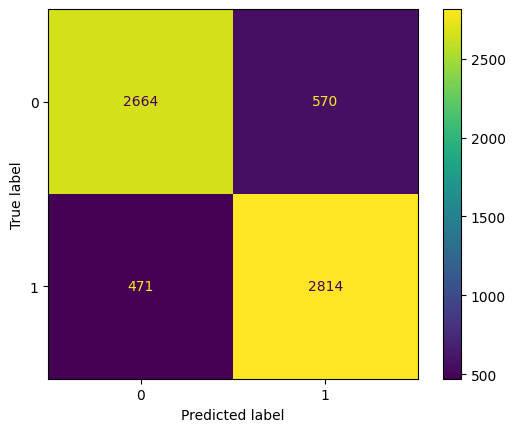

In [33]:
# Evaluate Model on training data
training_predictions = random_forest.predict(training_input)
display_result_metrics(training_output, training_predictions)

Accuracy: 0.8026678932842686
Precision: 0.7897033158813264
Recall: 0.827996340347667
F1 Score: 0.8083966056275123


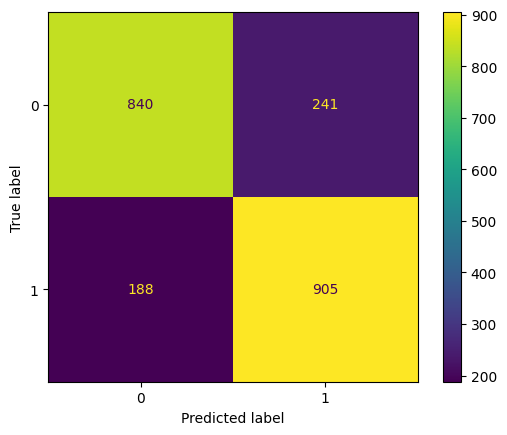

In [34]:
# Evaluate model on validation data
validation_predictions = random_forest.predict(validation_input)
display_result_metrics(validation_output, validation_predictions)

# Cleaning Test Data

In [35]:
testing_data = pd.read_csv("Data/test.csv")

In [36]:
# Split Passenger ID into Group number and position columns
testing_data[["GroupNum", "GroupPosition"]]= (
    testing_data
    .PassengerId
    .str
    .split("_", expand=True)
)

# Splitting Cabin into Deck, Room number, and side of ship 
testing_data[["Deck", "RoomNum", "Side"]] = (
    testing_data
    .Cabin
    .str
    .split("/", expand=True)
)

# Convert Data to proper types
testing_data["GroupNum"] = testing_data.GroupNum.astype('Int64')
testing_data["GroupPosition"] = testing_data.GroupPosition.astype('Int64')
testing_data["RoomNum"] = testing_data.RoomNum.astype('Int64')
testing_data["CryoSleep"] = testing_data.CryoSleep.astype(bool)
testing_data["VIP"] = testing_data.VIP.astype(bool)

# Converting Age into categorical variable
testing_data["Age"] = testing_data.Age.apply(group_ages)

# Extracting Passenger Id for submission
passenger_id = testing_data['PassengerId']

# Dropping Unused columns
testing_data = testing_data.drop(columns=["PassengerId", "Cabin", "Name"])

In [37]:
# One Hot encoding
testing_data = pd.get_dummies(testing_data)

In [38]:
# Filling in Nan values with median
for col_name in numerical_variables:
    if col_name != "Age":
        column_median = testing_data[col_name].median()
        testing_data[col_name] = testing_data[col_name].fillna(column_median)

# Assign nan for RumNumber -1, a dummay value representing room unknown
testing_data["RoomNum"] = testing_data["RoomNum"].fillna(-1)

In [39]:
# Aggregating spending into one column
testing_data["TotalSpent"] = testing_data.RoomService + testing_data.FoodCourt + testing_data.ShoppingMall + testing_data.Spa + testing_data.VRDeck

# Dropping low correlation columns
testing_data = testing_data.drop(columns=["Side_P", "GroupPosition", "GroupNum", "Destination_PSO J318.5-22", 'Destination_TRAPPIST-1e', "Age_Adult", "Age_Senior", "Age_Teen", "Age_Young Adult", "VIP"])

In [40]:
# Generate Test predictions
testing_predictions =  random_forest.predict(testing_data)

# Create DataFrame containing test predictions for each passenger id
testing_submission_dict = {
    'PassengerId': passenger_id,
    'Transported' : testing_predictions
}
testdf = pd.DataFrame(testing_submission_dict)

# Save to csv
testdf.to_csv('SpaceshipTitanicSubmission.csv', index=False)